<div style="text-align: center;">
<FONT size="8">
<BR><BR><b>
Stochastic Processes: <BR><BR>Data Analysis and Computer Simulation  
</b>
</FONT>
<BR><BR><BR>

<FONT size="7">
<b>
Brownian motion 3: data analyses
</b>
</FONT> 
<BR><BR><BR>

<FONT size="7">
<b>
-Mean square displacement and diffusion constant-
</b>
</FONT>
<BR>
</div>

#### Note 1

- In this plot, we will analyze the trajectories generated by our Brownian simulation code to calculate the diffusion constant using three different approaches based on the theoretical knowledge we introduced previously.
- First, we will use the mean-squared displacement and velocity auto-correlation function obtained from an equilibrium simulation.
- Then, we will perform a non-equilibrium simulation with an external drift force exerted on the Brownian particles and compute the diffusion constant from the average drift velocity.

# Calculating the diffusion constant from simulation data

## Perform simulation (at equilibrium)

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
dim  = 3    # system dimension (x,y,z)
nump = 1000 # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.05 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition Eq.(F12)
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition Eq.(F12)
W = np.zeros([nump,dim]) # array to store current random forcces
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time = np.zeros([nums]) # an array to store time at all steps
for i in range(nums): # repeat the following operations from i=0 to nums-1
    W = std*np.random.randn(nump,dim) # generate an array of random forces according to Eqs.(F10) and (F11)
    V = V*(1-zeta/m*dt)+W/m # update velocity via Eq.(F9)
    R = R + V*dt # update position via Eq.(F5)
    Rs[i]=R # accumulate particle positions at each step in an array Rs
    Vs[i]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

#### Note 2

- Let us perform a simulation to produce the trajectory data for the motion of 1000 non-interacting Brownian particles.
- As always, we begin by importing the usual numerical and plotting libraries.
- The code we use here, is exactly the same as the one we used in the previous lesson.
- We solve for the motion of 1000 Brownian particles and save the trajectory data for their position, velocity, and random forces at each time step.

## Mean square displacement vs. time

- Calculate the mean square displacement, and compare it with the following theoretical result (see the derivation for Eq.(30)).
$$
\langle[\mathbf{R}(t)-\mathbf{R}(0)]^2\rangle=6Dt\tag{H1}
$$
<br>
- Note that the diffusion coefficient can be easily calculated from the mean square displacement by integrating both sides of Eq.(H1) with respect to time
$$
D = \frac{1}{3 T^2} \int_0^T \mathrm{d} t \,\langle[\mathbf{R}(t) - \mathbf{R}(0)]^2\rangle\tag{H2}
$$

D = 1.0 (Theoretical)
D = 0.926874089843 (Simulation via MSD)


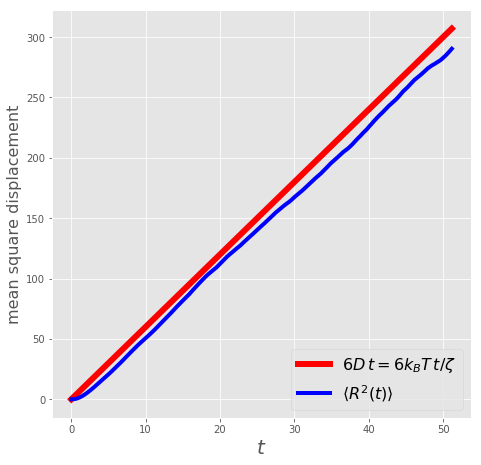

In [2]:
# mean square displacement vs time
msd = np.zeros([nums])
for i in range(nums): # loop over time steps
    for n in range(nump): # loop over particles
        msd[i]=msd[i]+np.linalg.norm(Rs[i,n,:])**2 # (R(t) - R(0))^2 = R(t)^2, since R(0) = 0 for all particles
    msd[i] = msd[i]/nump  # average over particles
dmsd = np.trapz(msd, dx=dt)/ (3*(nums*dt)**2) # integrate using trapezoidal rule
print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel(r"mean square displacement", fontsize=16)
ax.plot(time,6*kBT/zeta*time,'r',lw=6, label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time,msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=16,loc=4)
plt.show()

#### Note 3

- We first calculate the diffusion constant via the mean square displacement using Eq.(H1). 
- Note that since all the particles are initially at the origin, the displacement is simply given by the particle position.
- In the code shown here, we define an array msd, of size 'nums', which gives the mean-squared displacement at each time step, averaged over all the particles.
- The diffusion constant can then be obtained by integrating the msd in time, as shown in Eq.(H2).
- We perform this integration using numpy's built in 'trapz' function, which evaluates the integral through the trapezoidal rule.
- The numerical value of the diffusion constant is 0.93, which is in good agreement with the theoretical prediction of 1.0.
- Finally, we have plotted the mean-square displacement as a function of time, and compared it with the theoretical value of $6 D t$, which gives a straight line of slope '6 D'.
- While the curves seem to be slightly different from each other, what is important here is the fact that the slope of the curves is the same, this means that the the diffusion constant is the same.

## Diffusion constant and Velocity auto-correlation function

- Calculate the velocity auto-correlation function, and evaluate the diffusion constant using the Green-Kubo formula (see the derivation for Eq.(49)).

$$
D=\frac{1}{3}\int_o^\infty \varphi_V(t) dt
\tag{H3}
$$

D = 1.0 (Theoretical)
D = 0.944777284634 (Simulation via Green-Kubo)


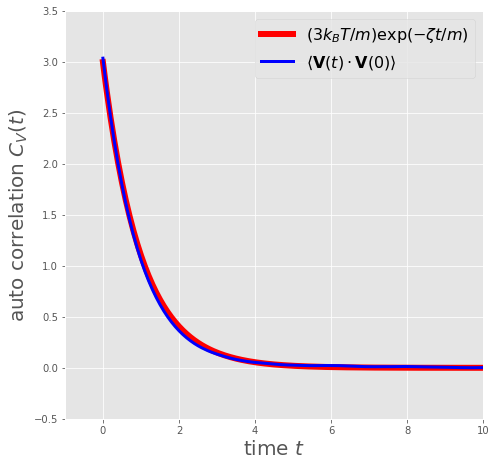

In [3]:
# compute self-correlation of vector v
def auto_correlate(v):
    # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
    corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
    return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points
corr = np.zeros([nums])
for n in range(nump):
    for d in range(dim):
        corr = corr + auto_correlate(Vs[:,n,d]) # correlation of d-component of velocity for particle n
corr=corr/nump #average over all particles
print('D =',kBT/zeta,'(Theoretical)')
print('D =',np.trapz(corr,dx=dt)/3,'(Simulation via Green-Kubo)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.plot(time,dim*kBT/m*np.exp(-zeta/m*time),'r',lw=6, label=r'$(3k_BT/m)\exp(-\zeta t/m)$')
ax.plot(time,corr,'b',lw=3,label=r'$\langle\mathbf{V}(t)\cdot \mathbf{V}(0)\rangle$')
ax.set_xlabel(r"time $t$", fontsize=20)
ax.set_ylabel(r"auto correlation $C_V(t)$", fontsize=20)
ax.set_xlim(-1,10)
ax.set_ylim(-0.5,3.5)
ax.legend(fontsize=16)
plt.show()

#### Note 4

- Next, we calculate the diffusion constant via the Green-Kubo formula using Eq.(H3).
- In the code example, we again use the built-in 'correlate' function to compute the velocity correlation function.
- To obtain the appropriate average, we sum over the correlations for the x,y,and z components for all particles.
- The diffusion constant is then obtained by integrating this correlation function in time and dividing by three.
- The evaluated value of the diffusion constant is now 0.94, which is again in good agreement with the theoretical prediction.
- In the figure, we have plotted both the the correlation function computed from the simulation, as well as the theoretical curve.
- The agreement between the two is excellent.

## Perform simulation under external force (out of equilibrium)

In [ ]:
dim  = 3    # system dimension (x,y,z)
nump = 1000 # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.05 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
F0   = 1.0  # set external drift force
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition Eq.(F12)
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition Eq.(F12)
W = np.zeros([nump,dim]) # array to store current random forcces
F = np.zeros([nump,dim]) # array to store external force
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time  = np.zeros([nums]) # an array to store time at all steps
F[:,0]=F0 # constant force along x, zero force in y and z
for i in range(nums): # repeat the following operations from i=0 to nums-1
    W = std*np.random.randn(nump,dim) # generate an array of random forces accordingly to Eqs.(F10) and (F11)
    V = V*(1-zeta/m*dt)+W/m+F/m*dt # update velocity via Eq.(F9)
    R = R + V*dt # update position via Eq.(F5)
    Rs[i]=R # accumulate particle positions at each step in an array Rs
    Vs[i]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

#### Note 5

- The third method we use to evaluate the diffusion constant is to apply an external drift force.
- In this example, we will add a constant external force in the x-direction to all the particles.
- By measuring the response of the system, in particular the average velocity along the x-direction, we will be able to compute the diffusion constant.
- The code we use here is exactly the same as before, the only difference is the addition of the external force 'F0'.
- The force is defined in lines 8 and 14, and used in line 22 to update the particle velocities (in addition to the friction and random forces).

## Drift velocity under external force

- Calculate the drift velocity $\langle V_x \rangle_{ext}$, and evaluate the diffusion constant using the equation shown here (see the derivation for Eq.(43)).

$$
D=\frac{\langle V_x \rangle_{ext}k_BT}{F_0}
\tag{H4}
$$

In [ ]:
Vsa = np.average(Vs,axis=1) # average over particles (0-axis is time, 1-axis is particles, 2-axis is dimension)
Vx  = np.average(Vsa[:,0]) # time average of (particle averaged) x-velocity
print('D =',kBT/zeta, '(Theoretical)')
print('D =',Vx*kBT/F0,'(Simulation with external force)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.set_ylabel(r"$V_{\alpha}(t)$", fontsize=20)
ax.set_xlabel(r"$t$", fontsize=20)
ax.plot(time,F0/zeta*np.ones(nums),'k',lw=4,label=r"$F_0/\zeta=DF_0/k_B T$")
ax.plot(time,Vsa[:,0],'r',lw=2,label="$x$")
ax.plot(time,Vsa[:,1],'b',lw=2,label="$y$")
ax.plot(time,Vsa[:,2],'g',lw=2,label="$z$")
ax.legend(fontsize=16,loc=5)
plt.show()

#### Note 6

- We next calculate the diffusion constant under an external drift force using Eq.(H4).
- As shown in the equation, the diffusion constant is proportional to the average velocity along the x-direction (the direction along which the external force is applied).
- To evaluate the averages we make use of the builtin 'average' function.
- Here, we should be careful to specify the appropriate axis along which the average should be calculated.
- Vs, which contains the velocities of all particles for all times, is a 3D array, where the first axis referes to the time values, the second to the particle, and the third to the spatial dimension.
- Since we want an average over particles, we whould specify 'axis=1'. 
- This returns a 2D array 'Vsa', where the first axis refers to time, and the second to the spatial dimension.
- Finally, we compute the time-averaged x velocity by calling the 'average' function on 'Vsa[:,0]'. Note that we have selected only the x-component, so this is a 1D array and we do not need to explicitly specify the axis.
- The evaluated value of the diffusion constant is 0.98, which again is in excellent agreement with the theoretical prediction.
- In the figure, we have plotted the time evolution of the average particle velocity as a function of time.
- Note that the y and z velocities are fluctuating around zero, while the x component of the velocity fluctuates around a non-zero value determined by the diffusion constant.

## Homework

- Decrease the statistical error in the msd calculation by averaging over the time origin (this modification may cause very long time to execute the program).
- The built-in `correlate` function automatically does the same operation, thus the calculated curve for velocity auto correlation function is much smoother than msd.

In [ ]:
# calculate msd for single particle for maximum correlation time tau: pos = pos[nums, 3]
def diffusion0(pos, tau):
    return np.average(list(map(lambda dx: np.linalg.norm(dx, axis=1)**2, 
                        map(lambda r0,t0: pos[t0:t0+tau]-r0, pos[:nums-tau-1], range(nums-tau-1)))), axis=0)

# calculate msd for all particles for maximum correlation time tau: pos = pos[nums, nump, 3]
def diffusion(pos, tau):
#   return np.average(list(map(lambda i: diffusion0(pos[:,i,:], tau), range(nump))), axis=0)
    msd = np.zeros(tau)
    for i in range(nump):
        msd = msd + diffusion0(pos[:,i,:], tau)
    return msd/nump

In [ ]:
ntau  = nums//2 # correlation time
msd  = diffusion(Rs, ntau)
dmsd = np.trapz(msd, dx=dt)/ (3*(ntau*dt)**2) # integrate using trapezoidal rulen
print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel(r"mean square displacement", fontsize=16)
ax.plot(time[:ntau],6*kBT/zeta*time[:ntau],'r',lw=6, label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time[:ntau],msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=16,loc=4)
plt.show()